In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the CSV file into a pandas dataframe

df = pd.read_csv('../data/bank-additional-full.csv', sep=';')
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())

Dataset Shape: (41188, 21)

First 5 Rows:
    age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price

In [5]:
# Replace 'unknown' with NaN to treat as missing values

df.replace('unknown', pd.NA, inplace=True)
print("Missing Values Before:\n", df.isnull().sum())

# Fill missing values with the mode of each column

df.fillna(df.mode().iloc[0], inplace=True)
print("\nMissing Values After:\n", df.isnull().sum())

Missing Values Before:
 age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Missing Values After:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [6]:
# Define a function to detect outliers using IQR method

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

# Check outliers in numerical columns

numerical_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']
for col in numerical_cols:
    print(f"Outliers in {col}: {detect_outliers(df, col)}")

Outliers in age: 469
Outliers in duration: 2963
Outliers in campaign: 2406
Outliers in pdays: 1515
Outliers in previous: 5625


In [7]:
# Encode categorical columns using LabelEncoder

categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                   'contact', 'month', 'day_of_week', 'poutcome']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Encode the target variable 'y'

df['y'] = df['y'].map({'yes': 1, 'no': 0})

print("\nEncoded Data Sample:\n", df.head())


Encoded Data Sample:
    age  job  marital  education  default  housing  loan  contact  month  \
0   56    3        1          0        0        0     0        1      6   
1   57    7        1          3        0        0     0        1      6   
2   37    7        1          3        0        1     0        1      6   
3   40    0        1          1        0        0     0        1      6   
4   56    7        1          3        0        0     1        1      6   

   day_of_week  ...  campaign  pdays  previous  poutcome  emp.var.rate  \
0            1  ...         1    999         0         1           1.1   
1            1  ...         1    999         0         1           1.1   
2            1  ...         1    999         0         1           1.1   
3            1  ...         1    999         0         1           1.1   
4            1  ...         1    999         0         1           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0          93.994  

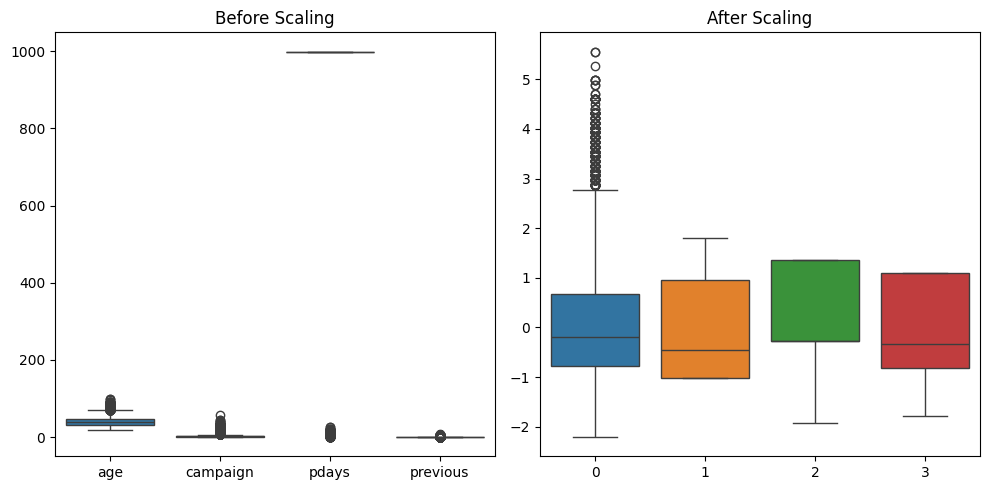

In [8]:
# Split features and target, remove 'duration' for realistic prediction

X = df.drop(['y', 'duration'], axis=1)
y = df['y']

# Split data into training (80%) and testing (20%) sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features using StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define numerical columns excluding 'duration' since it’s dropped

numerical_cols = ['age', 'campaign', 'pdays', 'previous']

# Visualize scaling effect with box plots

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train[numerical_cols])
plt.title('Before Scaling')
plt.subplot(1, 2, 2)
sns.boxplot(data=scaler.transform(X_train)[:, :len(numerical_cols)])
plt.title('After Scaling')
plt.tight_layout()
plt.show()

In [9]:
# Train Support Vector Machine model

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)

# Print SVM performance metrics

print("SVM Classification Report:\n", classification_report(y_test, svm_pred))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7303
           1       0.62      0.24      0.34       935

    accuracy                           0.90      8238
   macro avg       0.76      0.61      0.64      8238
weighted avg       0.88      0.90      0.88      8238



In [10]:
# Train Logistic Regression model

lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

# Print Logistic Regression performance metrics

print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_pred))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7303
           1       0.64      0.21      0.32       935

    accuracy                           0.90      8238
   macro avg       0.77      0.60      0.63      8238
weighted avg       0.88      0.90      0.87      8238



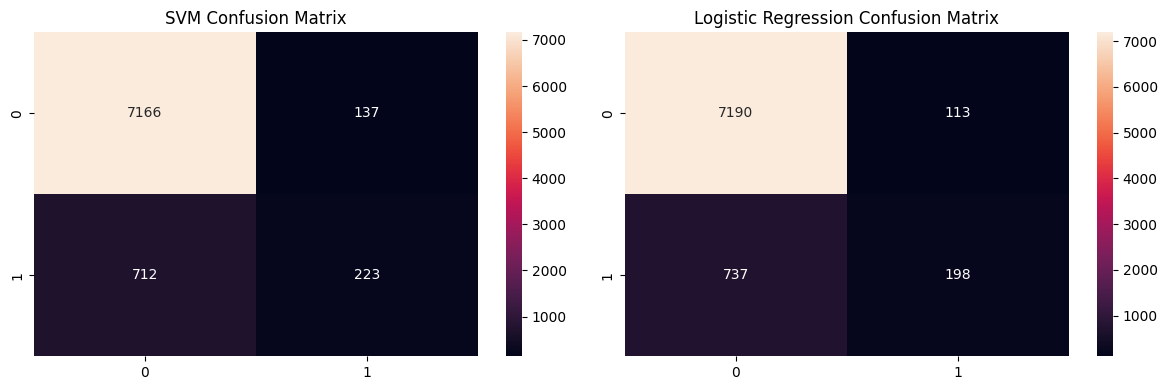

In [11]:
# Plot confusion matrices for both models

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d')
plt.title('SVM Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d')
plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.show()

In [12]:
# Save the trained model and scaler for AWS deployment

import pickle

with open('../lambda/lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)
with open('../lambda/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and Scaler saved to ../lambda/ folder!")

Model and Scaler saved to ../lambda/ folder!
